<h1> Import LibrarAies </h1>

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from xgboost import XGBRegressor


<h1> Explore The Data </h1>

In [13]:
df = pd.read_csv('laptop_price_kaggle.csv',index_col="laptop_ID",encoding="latin1")
df = df.drop(columns=["Product"])
df.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
laptop_ID,,,,,,,,,,,
1,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
2,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
3,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
4,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
5,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1303 entries, 1 to 1320
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1303 non-null   object 
 1   TypeName          1303 non-null   object 
 2   Inches            1303 non-null   float64
 3   ScreenResolution  1303 non-null   object 
 4   Cpu               1303 non-null   object 
 5   Ram               1303 non-null   object 
 6   Memory            1303 non-null   object 
 7   Gpu               1303 non-null   object 
 8   OpSys             1303 non-null   object 
 9   Weight            1303 non-null   object 
 10  Price_euros       1303 non-null   float64
dtypes: float64(2), object(9)
memory usage: 122.2+ KB


In [15]:
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")
    print(df[col].value_counts())
    print("***************************************")

Company: 19 unique values
Company
Dell         297
Lenovo       297
HP           274
Asus         158
Acer         103
MSI           54
Toshiba       48
Apple         21
Samsung        9
Razer          7
Mediacom       7
Microsoft      6
Xiaomi         4
Vero           4
Chuwi          3
Google         3
Fujitsu        3
LG             3
Huawei         2
Name: count, dtype: int64
***************************************
TypeName: 6 unique values
TypeName
Notebook              727
Gaming                205
Ultrabook             196
2 in 1 Convertible    121
Workstation            29
Netbook                25
Name: count, dtype: int64
***************************************
Inches: 18 unique values
Inches
15.6    665
14.0    197
13.3    164
17.3    164
12.5     39
11.6     33
12.0      6
13.5      6
13.9      6
12.3      5
10.1      4
15.4      4
15.0      4
13.0      2
18.4      1
17.0      1
14.1      1
11.3      1
Name: count, dtype: int64
***************************************
Screen

In [16]:
# Take the most common companies and label the rest as 'Other'
valid_companies = ["Apple", "Dell", "HP", "Lenovo", "Asus", "Acer", "MSI", "Toshiba"]
df["Company"] = df["Company"].where(df["Company"].isin(valid_companies), "Other")
df["Company"].value_counts()

Company
Dell       297
Lenovo     297
HP         274
Asus       158
Acer       103
MSI         54
Other       51
Toshiba     48
Apple       21
Name: count, dtype: int64

In [17]:
# Deal with ScreenResolution column we should extract Touchscreen and Ips and XxY resolution
df["Touchscreen"] = df["ScreenResolution"].apply(lambda x: 1 if "Touchscreen" in x else 0)
df["Ips"] = df["ScreenResolution"].apply(lambda x: 1 if "IPS" in x else 0)
df[["X_resolution", "Y_resolution"]] = df["ScreenResolution"].str.extract(r'(\d+)x(\d+)').astype(int)
df.drop(columns=["ScreenResolution"], inplace=True)
df.head()

,Company,TypeName,Inches,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,Touchscreen,Ips,X_resolution,Y_resolution
laptop_ID,,,,,,,,,,,,,,
1,Apple,Ultrabook,13.3,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69,0,1,2560,1600
2,Apple,Ultrabook,13.3,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94,0,0,1440,900
3,HP,Notebook,15.6,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00,0,0,1920,1080
4,Apple,Ultrabook,15.4,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45,0,1,2880,1800
5,Apple,Ultrabook,13.3,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60,0,1,2560,1600


## 🔍 Regex Breakdown: `r'(\d+)x(\d+)'`

* **`r'...'`** → raw string in Python (so `\d` means *digit*, not an escape sequence).
* **`(\d+)`** → capture **one or more digits**

  * `\d` = digit (`0–9`)
  * `+` = one or more
  * `( ... )` = capture group (stores the matched part)
* **`x`** → literally the character `"x"` (between width and height)
* **`(\d+)` (second one)** → capture one or more digits **after the `x`**

---

## 🎯 Example Match

Input:

```
"3840x2160"
```

Regex groups:

* **First `(\d+)`** → `3840` (X resolution)
* **`x`** → matches the middle `"x"`
* **Second `(\d+)`** → `2160` (Y resolution)

---

✅ This way, the regex extracts **width** and **height** separately:

| Group 1 | Group 2 |
| ------- | ------- |
| 3840    | 2160    |


In [18]:
# Deal with CPU column
def extract_cpu_brand(cpu):
    cpu = cpu.lower()
    if 'intel' in cpu:
        if 'i3' in cpu:
            return 'Intel Core i3'
        elif 'i5' in cpu:
            return 'Intel Core i5'
        elif 'i7' in cpu:
            return 'Intel Core i7'
        else:
            return 'Intel'
    elif 'amd' in cpu:
        return 'AMD'
    else:
        return 'Other'
    
df['CPU_Brand'] = df['Cpu'].apply(extract_cpu_brand)
df.drop(columns=['Cpu'], inplace=True)
df['CPU_Brand'].value_counts()

CPU_Brand
Intel Core i7    527
Intel Core i5    423
Intel            154
Intel Core i3    136
AMD               62
Other              1
Name: count, dtype: int64

In [19]:
df = df[df["CPU_Brand"] != "Other"]          # only 1 row with "Other" and it will not be good in encoding
df['CPU_Brand'].value_counts()

CPU_Brand
Intel Core i7    527
Intel Core i5    423
Intel            154
Intel Core i3    136
AMD               62
Name: count, dtype: int64

In [20]:
# Deal with RAM column
df['Ram'] = df['Ram'].str.replace('GB', '').astype(int)

In [21]:
# Deal with Memory column
def parse_memory(mem_str):
    mem_info = {"SSD": 0, "HDD": 0, "Flash_Storage": 0, "Hybrid": 0}
    
    # Find all "number + unit + type"
    matches = re.findall(r'(\d+\.?\d*)\s*(GB|TB)\s*(SSD|HDD|Flash Storage|Hybrid)', mem_str, flags=re.I)    #\.? = optional decimal point       ,\s* → zero or more spaces
    
    for size, unit, mtype in matches:
        size = float(size)
        if unit.upper() == "TB":
            size *= 1024  # convert TB → GB
        
        if "SSD" in mtype.upper():
            mem_info["SSD"] += int(size)
        elif "HDD" in mtype.upper():
            mem_info["HDD"] += int(size)
        elif "FLASH" in mtype.upper():
            mem_info["Flash_Storage"] += int(size)
        elif "HYBRID" in mtype.upper():
            mem_info["Hybrid"] += int(size)
    
    return pd.Series(mem_info)

# Apply function
df[["SSD", "HDD", "Flash_Storage", "Hybrid"]] = df["Memory"].apply(parse_memory)
df.drop(columns=["Memory"], inplace=True)
df.head()

,Company,TypeName,Inches,Ram,Gpu,OpSys,Weight,Price_euros,Touchscreen,Ips,X_resolution,Y_resolution,CPU_Brand,SSD,HDD,Flash_Storage,Hybrid
laptop_ID,,,,,,,,,,,,,,,,,
1,Apple,Ultrabook,13.3,8,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69,0,1,2560,1600,Intel Core i5,128,0,0,0
2,Apple,Ultrabook,13.3,8,Intel HD Graphics 6000,macOS,1.34kg,898.94,0,0,1440,900,Intel Core i5,0,0,128,0
3,HP,Notebook,15.6,8,Intel HD Graphics 620,No OS,1.86kg,575.00,0,0,1920,1080,Intel Core i5,256,0,0,0
4,Apple,Ultrabook,15.4,16,AMD Radeon Pro 455,macOS,1.83kg,2537.45,0,1,2880,1800,Intel Core i7,512,0,0,0
5,Apple,Ultrabook,13.3,8,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60,0,1,2560,1600,Intel Core i5,256,0,0,0


In [22]:
# Deal wuth GPU column
def extract_gpu_brand(gpu):
    gpu = gpu.lower()
    if 'nvidia' in gpu:
        return 'Nvidia'
    elif 'amd' in gpu:
        return 'AMD'
    elif 'intel' in gpu:
        return 'Intel'
    else:
        return 'Other'
df['GPU_Brand'] = df['Gpu'].apply(extract_gpu_brand)
#df.drop(columns=['Gpu'], inplace=True)
df['GPU_Brand'].value_counts()

GPU_Brand
Intel     722
Nvidia    400
AMD       180
Name: count, dtype: int64

<Axes: xlabel='Gpu'>

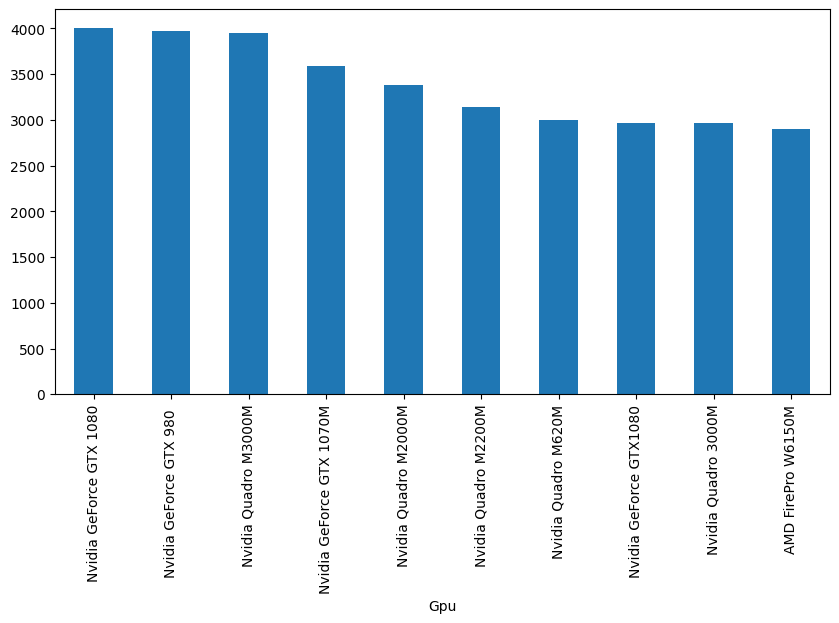

In [24]:
gpu_price = df.groupby("Gpu")["Price_euros"].mean().sort_values(ascending=False)
gpu_price.head(10).plot(kind="bar", figsize=(10,5))


In [25]:
print(gpu_price.head(15))
print("********************************")
print(gpu_price.tail(15))

Gpu
Nvidia GeForce GTX 1080     4007.333333
Nvidia GeForce GTX 980      3975.000000
Nvidia Quadro M3000M        3949.400000
Nvidia GeForce GTX 1070M    3588.800000
Nvidia Quadro M2000M        3379.500000
Nvidia Quadro M2200M        3146.000000
Nvidia Quadro M620M         2999.000000
Nvidia GeForce GTX1080      2968.000000
Nvidia Quadro 3000M         2968.000000
AMD FirePro W6150M          2899.000000
AMD Radeon Pro 560          2858.000000
Nvidia GTX 980 SLI          2799.000000
Nvidia GeForce GTX 1070     2611.805333
Nvidia Quadro M520M         2577.000000
AMD Radeon Pro 455          2537.450000
Name: Price_euros, dtype: float64
********************************
Gpu
AMD Radeon R5 430         499.000000
Intel HD Graphics 505     446.032500
AMD Radeon R5             444.080909
AMD Radeon R7             429.000000
Intel HD Graphics 510     412.975000
AMD Radeon R4             405.000000
Intel HD Graphics 405     403.110000
AMD R4 Graphics           399.000000
Intel HD Graphics         397

In [26]:
gpu_brand_price = df.groupby("GPU_Brand")["Price_euros"].mean().sort_values(ascending=False)
gpu_brand_price

GPU_Brand
Nvidia    1489.874250
Intel     1008.225582
AMD        775.647667
Name: Price_euros, dtype: float64

In [27]:
# Brand only doesn't affect price much but model does
print("Std by Brand:", gpu_brand_price.std())
print("Std by Model:", gpu_price.std())

Std by Brand: 364.2795489199033
Std by Model: 896.0752850713016


In [28]:
def extract_gpu_features(df, col="Gpu"):
    # 1. Integrated vs Dedicated
    df["Gpu_Type"] = df["GPU_Brand"].apply(
        lambda x: "Integrated" if x == "Intel" else "Dedicated"
    )

    # 2. Family (GTX, RTX, HD, UHD, MX, Vega, RX, etc.)
    df["Gpu_Family"] = df[col].str.extract(r'(GTX|RTX|MX|HD|UHD|Iris|R\d|RX|Vega)', expand=False)

    # 3. Model number (first number that appears in GPU string)
    df["Gpu_Model_Number"] = df[col].str.extract(r'(\d+)', expand=False)
    df["Gpu_Model_Number"] = pd.to_numeric(df["Gpu_Model_Number"], errors="coerce")


    # 4. Generation (bucket old/mid/new by model number)
    def classify_generation(row):
        num = row["Gpu_Model_Number"]
        if pd.isna(num):
            return "Unknown"
        if row["GPU_Brand"] == "Nvidia":
            if num < 900: return "Old"
            elif num < 2000: return "Mid"
            else: return "New"
        elif row["GPU_Brand"] == "AMD":
            if num < 500: return "Old"
            elif num < 2000: return "Mid"
            else: return "New"
        elif row["GPU_Brand"] == "Intel":
            if num < 600: return "Old"
            elif num < 1000: return "Mid"
            else: return "New"
        return "Unknown"

    df["Gpu_Generation"] = df.apply(classify_generation, axis=1)

    # 5. Mobile vs Desktop
    df["Gpu_Mobile"] = df[col].str.contains(r'M\b', regex=True).astype(int)

    # 6. Ray Tracing support (Nvidia RTX only)
    df["Gpu_RayTracing"] = df["Gpu_Family"].apply(lambda x: 1 if x == "RTX" else 0)

    return df

df = extract_gpu_features(df, col="Gpu")
df.drop(columns=['Gpu'], inplace=True)
df.head()

,Company,TypeName,Inches,Ram,OpSys,Weight,Price_euros,Touchscreen,Ips,X_resolution,...,HDD,Flash_Storage,Hybrid,GPU_Brand,Gpu_Type,Gpu_Family,Gpu_Model_Number,Gpu_Generation,Gpu_Mobile,Gpu_RayTracing
laptop_ID,,,,,,,,,,,,,,,,,,,,,
1,Apple,Ultrabook,13.3,8,macOS,1.37kg,1339.69,0,1,2560,...,0,0,0,Intel,Integrated,Iris,640.0,Mid,0,0
2,Apple,Ultrabook,13.3,8,macOS,1.34kg,898.94,0,0,1440,...,0,128,0,Intel,Integrated,HD,6000.0,New,0,0
3,HP,Notebook,15.6,8,No OS,1.86kg,575.00,0,0,1920,...,0,0,0,Intel,Integrated,HD,620.0,Mid,0,0
4,Apple,Ultrabook,15.4,16,macOS,1.83kg,2537.45,0,1,2880,...,0,0,0,AMD,Dedicated,NaN,455.0,Old,0,0
5,Apple,Ultrabook,13.3,8,macOS,1.37kg,1803.60,0,1,2560,...,0,0,0,Intel,Integrated,Iris,650.0,Mid,0,0


In [29]:
df["Gpu_Model_Number"] = df["Gpu_Model_Number"].fillna(000)

In [30]:
# Deal with OpSys column
df["OpSys"].value_counts()

OpSys
Windows 10      1072
No OS             66
Linux             62
Windows 7         45
Chrome OS         26
macOS             13
Mac OS X           8
Windows 10 S       8
Android            2
Name: count, dtype: int64

<Axes: xlabel='OpSys'>

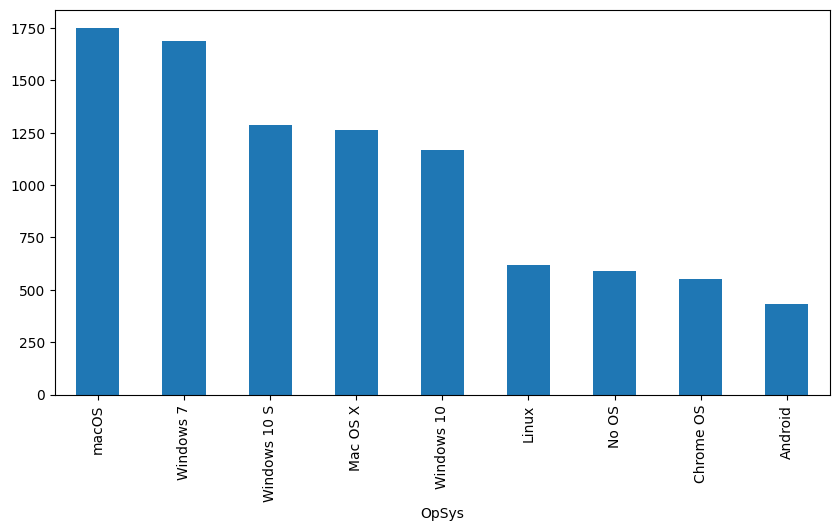

In [31]:
os_price = df.groupby("OpSys")["Price_euros"].mean().sort_values(ascending=False)
os_price.plot(kind="bar", figsize=(10,5))


In [32]:
print(df["Price_euros"].loc[df["OpSys"] == "Windows 10 S"].std())
print(df["Price_euros"].loc[df["OpSys"] == "Windows 10"].std())
# no big difference in std and mean so we can merge them

787.4424912697706
696.1156860132079


In [33]:
print(df["Price_euros"].loc[df["OpSys"] == "No OS"].std())
print(df["Price_euros"].loc[df["OpSys"] == "Chrome OS"].std())
print(df["Price_euros"].loc[df["OpSys"] == "Android"].std())
# There are slightly difference in std and mean but they have few samples so we can merge them all into "Other" category

277.15169055859496
478.88431569157143
162.63455967290594


In [34]:
def categorize_os(os):
    os = os.lower()
    if 'windows' in os:
        if 'windows 10' in os or 'windows 10 s' in os:
            return 'Windows 10'
        elif 'windows 7' in os or 'windows7' in os:
            return 'Windows 7'
        else:
            return 'Other Windows'
    elif 'mac' in os or 'ios' in os:
        return 'MacOS'
    elif 'linux' in os:
        return 'Linux'
    else:
        return 'Other'
    
df['OpSys'] = df['OpSys'].apply(categorize_os)
df['OpSys'].value_counts()

OpSys
Windows 10    1080
Other           94
Linux           62
Windows 7       45
MacOS           21
Name: count, dtype: int64

In [35]:
# Deal with Weight column
df['Weight'] = df['Weight'].str.replace('kg', '').astype(float)
df.head()

,Company,TypeName,Inches,Ram,OpSys,Weight,Price_euros,Touchscreen,Ips,X_resolution,...,HDD,Flash_Storage,Hybrid,GPU_Brand,Gpu_Type,Gpu_Family,Gpu_Model_Number,Gpu_Generation,Gpu_Mobile,Gpu_RayTracing
laptop_ID,,,,,,,,,,,,,,,,,,,,,
1,Apple,Ultrabook,13.3,8,MacOS,1.37,1339.69,0,1,2560,...,0,0,0,Intel,Integrated,Iris,640.0,Mid,0,0
2,Apple,Ultrabook,13.3,8,MacOS,1.34,898.94,0,0,1440,...,0,128,0,Intel,Integrated,HD,6000.0,New,0,0
3,HP,Notebook,15.6,8,Other,1.86,575.00,0,0,1920,...,0,0,0,Intel,Integrated,HD,620.0,Mid,0,0
4,Apple,Ultrabook,15.4,16,MacOS,1.83,2537.45,0,1,2880,...,0,0,0,AMD,Dedicated,NaN,455.0,Old,0,0
5,Apple,Ultrabook,13.3,8,MacOS,1.37,1803.60,0,1,2560,...,0,0,0,Intel,Integrated,Iris,650.0,Mid,0,0


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1302 entries, 1 to 1320
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1302 non-null   object 
 1   TypeName          1302 non-null   object 
 2   Inches            1302 non-null   float64
 3   Ram               1302 non-null   int32  
 4   OpSys             1302 non-null   object 
 5   Weight            1302 non-null   float64
 6   Price_euros       1302 non-null   float64
 7   Touchscreen       1302 non-null   int64  
 8   Ips               1302 non-null   int64  
 9   X_resolution      1302 non-null   int32  
 10  Y_resolution      1302 non-null   int32  
 11  CPU_Brand         1302 non-null   object 
 12  SSD               1302 non-null   int64  
 13  HDD               1302 non-null   int64  
 14  Flash_Storage     1302 non-null   int64  
 15  Hybrid            1302 non-null   int64  
 16  GPU_Brand         1302 non-null   object 
 17  

In [37]:
df["Gpu_Family"] = df["Gpu_Family"].fillna("Unknown")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1302 entries, 1 to 1320
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1302 non-null   object 
 1   TypeName          1302 non-null   object 
 2   Inches            1302 non-null   float64
 3   Ram               1302 non-null   int32  
 4   OpSys             1302 non-null   object 
 5   Weight            1302 non-null   float64
 6   Price_euros       1302 non-null   float64
 7   Touchscreen       1302 non-null   int64  
 8   Ips               1302 non-null   int64  
 9   X_resolution      1302 non-null   int32  
 10  Y_resolution      1302 non-null   int32  
 11  CPU_Brand         1302 non-null   object 
 12  SSD               1302 non-null   int64  
 13  HDD               1302 non-null   int64  
 14  Flash_Storage     1302 non-null   int64  
 15  Hybrid            1302 non-null   int64  
 16  GPU_Brand         1302 non-null   object 
 17  

<Axes: >

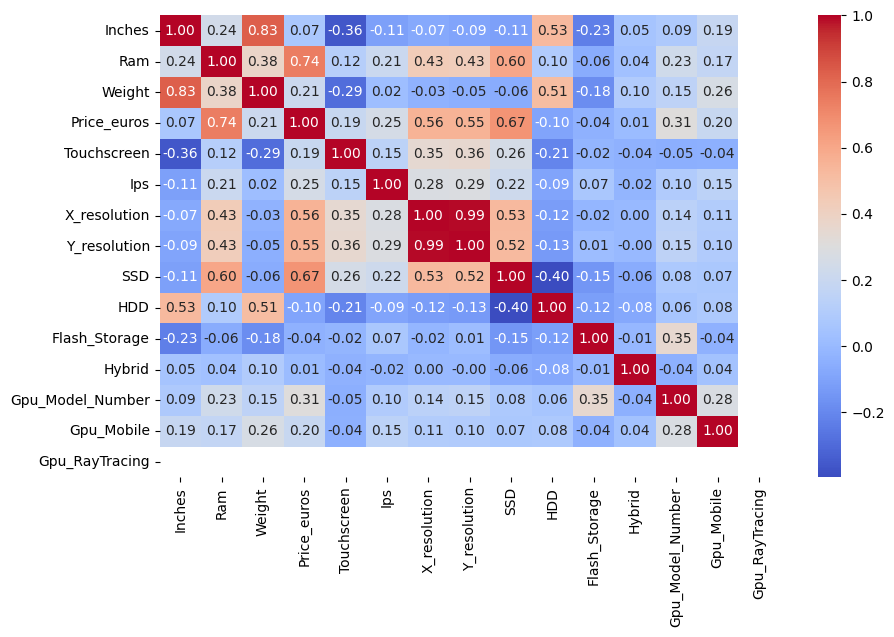

In [38]:
# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True, cmap="coolwarm", fmt=".2f")

In [39]:
# Weight and Inches are multicollinear so we can drop one of them
# Weight is higher correlated with Price than Inches
df.drop(columns=["Inches"], inplace=True)

<h1> Build The Model </h1>

In [40]:
X = df.drop(columns=["Price_euros"])  
y = df["Price_euros"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
# XGBoost Regressor
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    subsample=0.8,
    tree_method='hist',
    enable_categorical=True,
    random_state=42
)

In [42]:
cat_cols = df.select_dtypes(include=["object"]).columns
for col in cat_cols:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

In [43]:
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
r2 = r2_score(y_test, y_pred)
r2


0.8804927490469533